In [19]:
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt

k_factor = 0.1
rm = 0.005  
factor = 1.0208582
voxelr = factor*rm
L = 200*voxelr
print 'L',L
D = 1
kd= 4.0*math.pi*D*4*rm
ka = k_factor*kd
r0=0.256318
kac = 6*2**0.5*(2*D)*voxelr*(1./r0 -1)*ka/kd
kon = (ka*kd)/(ka+kd)
#tm =(2*voxelr)**2/(6*D)
N = 1000
duration = -math.log(0.01)/N/kon
dt=duration/10
w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
Vr = w.calculate_volume(ones()*L,rm)
lx,ly,lz = tuple(w.calculate_shape(ones()*L,voxelr))
Nv = lx*ly*lz
vv = w.calculate_voxel_volume(voxelr)
phi = 2.*N/Nv
print 'Vr',Vr
print ka,kd,kon
print 'phi',phi*100,'phir',2*N*100*vv/Vr



L 1.0208582
Vr 1.11191127128
0.0251327412287 0.251327412287 0.0228479465716
phi 0.136317040721 phir 0.135313500736


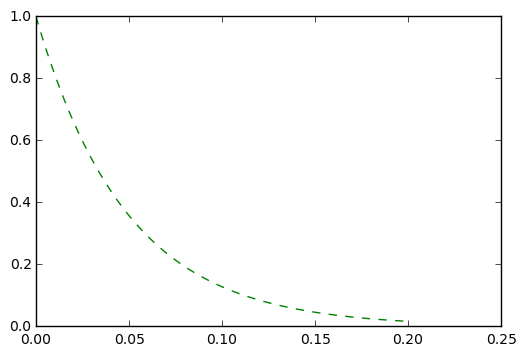

In [20]:
with reaction_rules():#for ODE
    A +B > B | kon

m1 = get_model()

ode = np.array(run_simulation(duration, model=m1, y0={'A': N,'B': N}, solver='ode', volume=Vr, return_type='array'))
to = ode[:,0]
nao = ode[:,1]

plt.plot(to,nao/N,'g--')

In [3]:
with species_attributes():
    A |B|C | {'D': str(D), 'radius':str(voxelr)}

with reaction_rules():#for spa and egfrd
    A + B > B | kac

m2 = get_model()

def singlerun(i):
    rng = GSLRandomNumberGenerator()
    rng.seed(i)
    #w = spatiocyte.create_spatiocyte_world_cell_list_impl(ones() * L, voxelr, Integer3(3, 3, 3), rng)
    w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr,rng)
    w.bind_to(m2)
    #ll= tuple(w.actual_lengths())
    #print ll[0]*ll[1]*ll[2]
    w.add_molecules(Species('A'), N)
    w.add_molecules(Species('B'), N)
    obs = FixedIntervalNumberObserver(dt, ('A'))
    sim = spatiocyte.SpatiocyteSimulator(w)
    sim.initialize()
    sim.run(duration, obs)    
    return np.array(obs.data())


In [4]:
def rung(run):   
    leng = int((duration/dt)+1)
    n = np.empty([run,leng])
    for i in range(run):
        spa = gfrd(i)
        n[i] = spa[:,1]        
    ts = spa[:,0]
    return ts,n

def rungtest(run):   
    spa = rungfrd(1)
    return spa[:,0]  ,spa[:,1]

def runspa(run):   
    leng = int((duration/dt)+1)
    n = np.empty([run,leng])
    for i in range(run):
        spa = singlerun(i)
        n[i] = spa[:,1]        
    ts = spa[:,0]
    return ts,n


In [5]:
run = 10000
#te,nae = rungtest(run)
#print len(te)
ts,nas = runspa(run)


In [6]:
mean = np.mean(nas,axis=0)/N
std = np.std(nas,axis=0)/N

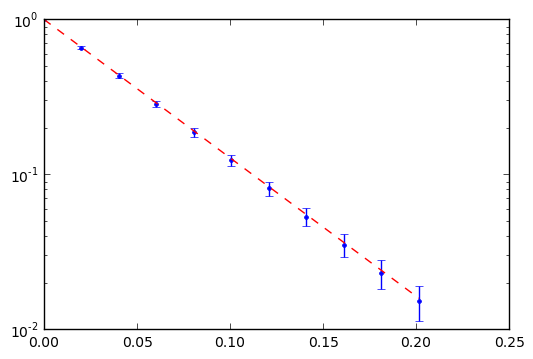

In [21]:
plt.errorbar(ts,mean,std,fmt=' ',marker='.')
plt.semilogy(to,nao/N,'r--')

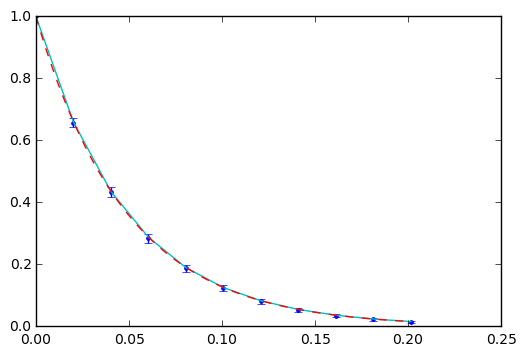

In [22]:
#Ct =1.02085
#r0=0.256318
#voxelr = 0.005/Ct
#kd = 4*np.pi*4*D*voxelr
#kaa = k_factor*4.0*math.pi*D*4*0.005
#Pa = kaa/(3*(2**0.5)*D*4*0.005)
#ka = Pa*kd/(1/r0 -1)
#kon = (ka*kd)/(ka+kd)
#Vr = w.calculate_volume(ones()*L,voxelr)

#import scipy.integrate as integrate
def Phi(xx):
    return 1./( (377.*xx/324)+(1+ (314.*(xx**2)/847) )**0.5)

tau = ((ka*2*rm/(ka+kd))**2)/(2*D)
#tt= np.linspace(0,0.5,1e3)
#def kt(t):
#    x=ka*((t/tau)**(0.5))/kd
#    return kon*(1+(ka*phi(x)/kd))
#intkt = [integrate.quad(lambda t: kt(t),0,T)[0] for T in tt] 

tt=ts
intkt = [kon*(t+tau*((kd/ka)*(Phi(ka*((t/tau)**(0.5))/kd)-1)+2*(math.sqrt(t/np.pi/tau)))) for t in tt]

st = [math.exp(-ik*N/Vr) for ik in intkt]
plt.errorbar(ts,mean,std,fmt=' ',marker='.')
plt.plot(tt,st,'c-')
plt.plot(to,nao/N,'r--')
#plt.ylim(0.4,1)

1.72687460399


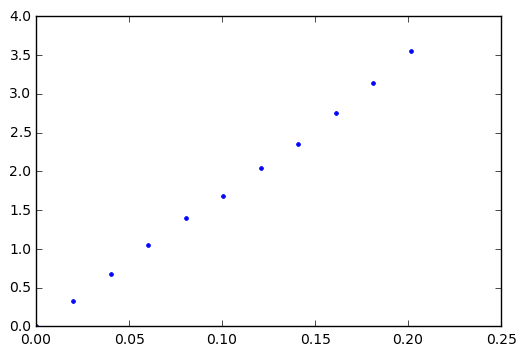

In [23]:
diff = (st-mean)*100/(st)
plt.plot(ts,diff,'.')
print np.mean(diff)